In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = psutil.Process(os.getpid())
print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print("GPU Model: ", gpu.name)

In [2]:
#Загружаем библиотеки

import pandas as pd # Пандас
import matplotlib.pyplot as plt # Отрисовка графиков
from tensorflow.keras import utils # Для to_categorical
import numpy as np # Numpy
from keras.optimizers import Adam # Оптимизатор
from keras.models import Sequential, Model # Два варианты моделей
from keras.layers import concatenate,Reshape, Input,Conv2DTranspose, Lambda, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Activation, GlobalMaxPooling1D, UpSampling1D#Стандартные слои
from keras.losses import MAE
from google.colab import files # Загрузка файлов
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Нормировщики
from keras.preprocessing.sequence import TimeseriesGenerator # Для генерации выборки временных рядов
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
import random as random # Импортируем модель randim
import numpy as np # Импортируем библиотеку numpy
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from PIL import Image # Импортируем одель Image для обработки изображений
import time
from tensorflow.keras.utils import plot_model
# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

In [9]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

--2021-04-12 17:43:29--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 570429 (557K) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv.1’

time_series_covid19 100%[===================>] 557.06K  --.-KB/s    in 0.04s   

2021-04-12 17:43:29 (13.0 MB/s) - ‘time_series_covid19_confirmed_global.csv.1’ saved [570429/570429]



In [10]:
# Считываем данные с помощью pandas
base_data = pd.read_csv('time_series_covid19_confirmed_global.csv')
data = base_data.iloc[1:, :]
# Выводим пять первых строк
#data

In [12]:
data = data.drop(['Province/State'], axis =1)  
data = data.drop(['Lat'], axis =1)  
data = data.drop(['Long'], axis =1) 
data = data[data['Country/Region'].str.contains('Russia')]
data = data.drop(['Country/Region'], axis =1)
data.reset_index(inplace=True)                                                    # Обновим индекс
data = data.drop('index',axis=1)                                                   # Выкинем ненужную, образовавшуюся после предыдущей операции колонку

In [13]:
data.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21
0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,4230707,4241970,4252876,4263785,4274263,4284408,4293750,4302726,4311893,4321588,4331396,4341381,4350728,4360033,4368943,4378656,4388268,4397816,4407031,4416226,4424595,4433364,4442492,4451565,4460348,4469327,4477916,4486078,4494234,4503291,4511973,4520879,4529576,4538101,4546307,4554481,4563026,4572053,4580633,4589209


In [14]:
data = np.array(data) 
data = data.transpose()
arr = []
i = 0
while i < len(data)-1:
  #print(data[i+1]-data[i])
  arr.append(data[i+1]-data[i])
  i += 1
data = np.array(arr)  

In [16]:
#Формируем параметры загрузки данных

valLen = 50  # Используем 300 записей для проверки
trainLen = data.shape[0]-valLen # Размер тренировочной выборки
xLen = 30     # Анализируем по 300 прошедшим точкам

Scaler = MinMaxScaler()
Scaler.fit(data)
# Делим данные на тренировочную и тестовую выборки 
#Train,Test = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen-1:],(-1,1))
Train,Test = np.reshape(data[:],(-1,1)), np.reshape(data[:],(-1,1))


# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)



# Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(Train, Train,             # в качестве параметров наши выборки
                               length=xLen, sampling_rate=1, # для каждой точки
                               batch_size=len(Train))                # размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(Test, Test,
                               length=xLen, sampling_rate=1,
                               batch_size=20)



In [17]:

xVal = []
yVal = []
for i in trainDataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

xTrain, xTest, yTrain, yTest = train_test_split(xVal[0], yVal[0], test_size=0.2)

print(len(trainDataGen))
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(data[:trainLen].shape)
print(data.shape[0] - trainLen)
#print(xTrain[0])


1
(332, 30, 1)
(332, 1)
(83, 30, 1)
(395, 1)
50


Функции для отображения результатов

In [18]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
# showGraf - показываем график или нет
# returnData - возвращаем массивы автокорреляции или нет
def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    if showGraf: #Если нужно показать график
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if showGraf: #Если нужно показать график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if returnData: #Если нужно вернуть массивы автокорреляции
    return corr, own_corr


# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()    

In [19]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(Test, Test,
                               length=xLen, sampling_rate=1,
                               batch_size=len(Test)) # Размер batch будет равен длине нашей выборки


Test =  np.reshape(data[:],(-1,1))

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
#Train = Scaler.transform(Train)
Test = Scaler.transform(Test)
DataGen = TimeseriesGenerator(Test, Test,
                              length=xLen, sampling_rate=1,
                              batch_size=len(Test)) # Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [20]:
#Создаём сеть (net - список параметров)
def createConvNet(net):

  model = Sequential()             # Создаем моель Sequential
  
  makeFirstNormalization = net[0]  # Делаем ли нормализацию в начале
  firstConvSize = 2 ** net[1]      # Размер первого вёрточного слоя
  firstConvKernel = net[2]         # Ядро первого свёрточного слоя
  activation0 = net[3]             # Функция активации входного слоя
  makeMaxPooling0 = net[4]         # Делаем ли maxpooling для нулевого слоя
  maxPoolingSize0 = net[5]         # Размер MaxPooling

  makeSecondConv = net[6]          # Делаем ли второй свёрточный слой
  secondConvSize = 2 ** net[7]     # Размер второго свёрточного слоя
  secondConvKernel = net[8]        # Ядро второго свёрточного слоя
  makeMaxPooling1 = net[9]         # Делаем ли MaxPooling
  maxPoolingSize1 = net[10]        # Размер MaxPooling
  activation1 = net[11]            # Функция активации

  makeThirdConv = net[12]          # Делаем ли второй свёрточный слой
  thirdConvSize = 2 ** net[13]     # Размер второго свёрточного слоя
  thirdConvKernel = net[14]        # Ядро второго свёрточного слоя
  makeMaxPooling2 = net[15]        # Делаем ли MaxPooling
  maxPoolingSize2 = net[16]        # Размер MaxPooling
  activation2 = net[17]            # Функция активации

  activation3 = net[18]            # Функция активации для 
  activation4 = net[19]            # Функция активации для последнего слоя

  makeSecondNormalization = net[20] # Делаем ли финальную нормализацию
  denseSize = 2 ** net[21]          # Размер полносвязного слоя

  activation_list = ['linear','relu','tanh','softmax','sigmoid'] 

  if (makeFirstNormalization):      # Если делаем нормализацию в начале

    # Добавляем слой BatchNormalization
    model.add(BatchNormalization(input_shape=(xLen, 1))) 

    # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
    model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding='same')) 
  else:

    # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
    model.add(Conv1D(firstConvSize, firstConvKernel, input_shape=(xLen, 1), activation=activation_list[activation0], padding='same')) 

  if makeMaxPooling0:               # Если делаем maxpooling
    model.add(MaxPooling1D(maxPoolingSize0))


  if (makeSecondConv):              # Если делаем второй свёрточный слой
    # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
    model.add(Conv1D(secondConvSize, secondConvKernel, activation=activation_list[activation1], padding='same')) 
    
    if (makeMaxPooling1):           # Если делаем MaxPooling
      # Добавляем слой MaxPooling1D с размером (maxPoolingSize)
      model.add(MaxPooling1D(pool_size=maxPoolingSize1)) 


  if (makeThirdConv):               # Если делаем второй свёрточный слой
    # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
    model.add(Conv1D(thirdConvSize, thirdConvKernel, activation=activation_list[activation2], padding='same')) 

    if (makeMaxPooling2):           # Если делаем MaxPooling
      # Добавляем слой MaxPooling1D с размером (maxPoolingSize, maxPoolingSize)
      model.add(MaxPooling1D(pool_size=maxPoolingSize2)) 
          
  if (makeSecondNormalization):     # Если делаем финальную нормализацию
    model.add(BatchNormalization()) # Добавляем слой BatchNormalization
  
  model.add(Flatten())              # Добавляем слой Flatten

  model.add(Dense(denseSize, activation=activation_list[activation3])) # Добавляем слой Dense с denseSize нейронами
  model.add(Dense(1, activation=activation_list[activation4]))         # Добавляем Dense-слой с softmax-активацией и 10 нейронами
  
  return model                      # Возвращаем модель

'''
  Функция вычисления результата работы сети
'''

def evaluateNet(net, ep, verb):
  val = 0
  time.time()
  model = createConvNet(net) # Создаем модель createConvNet

  # Компилируем модель
  model.compile(optimizer=Adam(lr=1e-4),
                  loss='mse')

  #history = model.fit_generator(trainDataGen,
  #                  epochs=5, 
  #                  verbose=verb,
  #                  validation_data=testDataGen)
  
  history = model.fit(xTrain, 
                    yTrain,
                    epochs=ep, 
                    verbose=verb,
                    validation_data=(xTest, yTest))
    
  val = history.history["val_loss"][-1] # Возвращаем точность на проверочной выборке с последней эпохи
  
  return val, model                      # Возвращаем точность

'''
  Функция создания списка случайных параметров
'''
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) #Делаем или нет нормализацию
  net.append(random.randint(3,6)) #Первый свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) #Ядро первого свёрточного слоя от 3 до 7
  net.append(random.randint(0,4)) # Функция активации первого слоя
  net.append(random.randint(0,1)) #Делаем ли MaxPooling
  net.append(random.randint(2,5)) #Размер MaxPooling

  net.append(random.randint(0,1)) # Сколько делаем еще сверточных слоев
  net.append(random.randint(3,6)) # Второй свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1)) # Делаем ли MaxPooling
  net.append(random.randint(2,5)) # Размер MaxPooling
  net.append(random.randint(0,4)) # Функция активации второго слоя

  net.append(random.randint(0,1)) # Сколько делаем еще сверточных слоев
  net.append(random.randint(3,6)) # Второй свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1)) # Делаем ли MaxPooling
  net.append(random.randint(2,5)) # Размер MaxPooling
  net.append(random.randint(0,4)) # Функция активации второго слоя

  net.append(random.randint(0,4)) # Функция активации предпоследнего dense слоя
  net.append(random.randint(0,2)) # Функция активации последнего слоя

  net.append(random.randint(0,1)) # Делаем ли финальную нормализацию слой
  net.append(random.randint(3,6)) # Размер полносвязного слоя от 8 до 64
  
  return net

In [ ]:
n = 20              # Общее число ботов
nsurv = 10          # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv    # Количество новых (столько новых ботов создается)
l = 22              # Размер бота
epohs = 20          # количество эпох

mut = 0.09          # коэфициент мутаций

popul = []          # Массив популяции
val = []            # Одномерный массив значений этих ботов

#Создаём случайных ботов
for i in range(n):
  popul.append(createRandomNet())
  
for it in range(epohs):                 # Пробегаем по всем эпохам
  val = []                              # Обнуляем значения бота
  curr_time = time.time()
  for i in range(n):                    # Пробегаем в цикле по всем ботам 
    bot = popul[i]                      # Берем очередного бота
    f, model_sum = evaluateNet(bot, 75, 0) # Вычисляем точность текущего бота
    val.append(f)                       # Добавляем полученное значение в список val
  
  sval = sorted(val, reverse=0)         # Сортируем val
  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) 
  
  newpopul = []                         # Создаем пустой список под новую популяцию
  for i in range(nsurv):                # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew):                 # Проходимся в цикле nnew-раз  
    indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
    newbot = []                         # Создаем пустой список под значения нового бота    
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(l):                  # Пробегаем по всей длине размерности (784)      
      x = 0      
      pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      
      # С вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]
        
      newbot.append(x)                  # Добавляем очередное значение в нового бота      
    newpopul.append(newbot)             # Добавляем бота в новую популяцию      
  popul = newpopul                      # Записываем в popul новую посчитанную популяцию

In [ ]:
print(popul) #Геномы лучших ботов по эпохам

[[1, 4, 3, 0, 1, 2, 1, 5, 6, 0, 2, 1, 0, 3, 7, 1, 5, 2, 0, 2, 0, 4], [1, 4, 3, 1, 1, 2, 1, 5, 6, 0, 2, 0, 0, 6, 7, 1, 5, 2, 0, 2, 0, 3], [1, 4, 3, 1, 1, 2, 1, 5, 6, 0, 3, 0, 0, 6, 7, 1, 5, 2, 0, 2, 0, 4], [1, 4, 3, 1, 1, 2, 1, 5, 6, 0, 2, 0, 0, 6, 3, 1, 5, 2, 0, 2, 0, 4], [1, 4, 3, 1, 0, 2, 1, 5, 6, 0, 2, 0, 0, 4, 7, 1, 5, 2, 2, 2, 0, 3], [1, 4, 3, 0, 1, 2, 1, 3, 6, 0, 2, 1, 0, 6, 7, 1, 5, 2, 0, 2, 0, 4], [1, 4, 6, 1, 0, 2, 1, 6, 6, 0, 2, 0, 0, 4, 7, 1, 5, 2, 0, 2, 0, 4], [1, 4, 6, 1, 1, 2, 1, 6, 6, 0, 2, 0, 0, 4, 7, 0, 5, 2, 0, 2, 0, 3], [1, 4, 3, 1, 1, 2, 1, 5, 6, 0, 2, 0, 0, 5, 7, 1, 5, 2, 0, 2, 0, 4], [1, 4, 6, 1, 0, 2, 1, 6, 6, 0, 2, 0, 0, 4, 7, 1, 5, 2, 0, 2, 0, 3], [1, 4, 3, 1, 1, 2, 1, 5, 6, 0, 3, 0, 0, 6, 7, 1, 5, 2, 0, 2, 0, 4], [1, 4, 3, 1, 0, 2, 1, 3, 6, 0, 2, 1, 0, 6, 7, 1, 5, 2, 0, 2, 0, 4], [1, 4, 6, 1, 0, 4, 1, 6, 6, 0, 2, 0, 0, 4, 7, 1, 5, 2, 0, 2, 1, 4], [0, 4, 6, 1, 0, 2, 0, 6, 6, 0, 2, 1, 1, 4, 7, 1, 5, 2, 0, 2, 0, 4], [1, 6, 6, 0, 1, 2, 1, 6, 6, 0, 2, 0, 0, 4, 7, 1

In [22]:
#model = createConvNet(popul[0])
model = createConvNet([0, 3, 4, 1, 0, 4, 1, 5, 5, 0, 4, 1, 0, 3, 5, 1, 5, 3, 2, 0, 0, 4])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 30, 8)             40        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 32)            1312      
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                15376     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 16,745
Trainable params: 16,745
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path,
                                      monitor='loss',
                                      save_best_only=True,
                                      verbose=0)

#Комипилируем и обучаем
model.compile(optimizer=Adam(lr=1e-4),
              loss='mse'
              #,metrics=['accuracy']
              )

history = model.fit(xTrain, 
                    yTrain,
                    epochs=100, 
                    validation_data=(xTest, yTest),
                    verbose = False
                    ,callbacks=[checkpoint_callback]
                    )

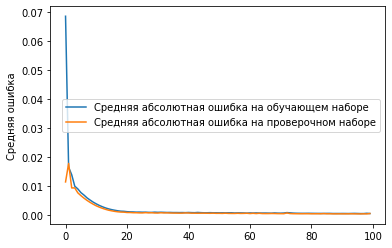

In [24]:
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

(415, 1)


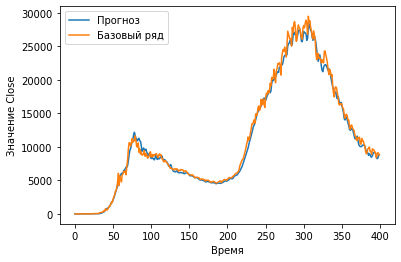

In [25]:
# Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные
print(yVal[0].shape)

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

In [ ]:
predVal[0][0]

77.29932

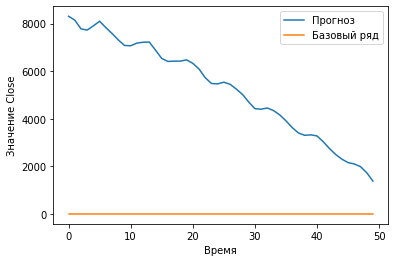

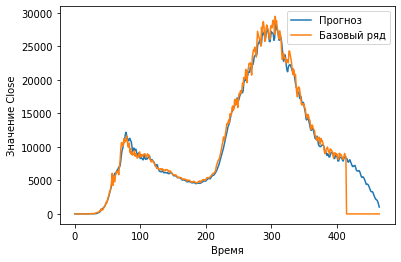

In [26]:
# Делаем прогноз на 365 дней
prognoz_days = 50
predict_arr = []
result_temp = []
ot = xVal[0].shape[0] - 1
do = ot + prognoz_days
kursor_pred = np.reshape(xVal[0][ot],(1, xLen, -1)) # берем последний набор из массива и предсказываем его
while ot <= do:
  predict_arr.append(np.reshape(kursor_pred[0],(xLen, -1))) # решейпим
  result_temp.append(0) # Костыль чтобы рисовать график
  predVal = currModel.predict(kursor_pred) # получаем значение для набора
  temp = kursor_pred[0][1:xLen] 
  temp = np.append(temp, predVal) # Добавляем прогнозируемое значение в конец следующего набора
  temp = np.reshape(temp,(-1,1))
  temp = np.reshape(temp,(1, xLen, -1))
  kursor_pred = temp
  ot += 1

predict_arr = np.array(predict_arr)
result_temp = np.array(result_temp)
result_temp = np.reshape(result_temp,(-1,1))

# Прогнозируем данные текущей сетью 
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, predict_arr, result_temp, Scaler) #Прогнозируем данные
# Отображаем графики
showPredict(0, prognoz_days, 0, predVal, yValUnscaled)

predict_arr = np.append(xVal[0], predict_arr)
predict_arr = np.reshape(predict_arr,(-1, xLen, 1))
result_temp = np.append(yVal[0], result_temp)
result_temp = np.reshape(result_temp,(-1, 1))

# Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, predict_arr, result_temp, Scaler) #Прогнозируем данные

# Отображаем графики
showPredict(0, result_temp.shape[0], 0, predVal, yValUnscaled)

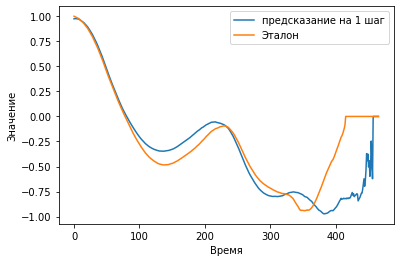

In [27]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
autoCorr([0], len(predVal), predVal, yValUnscaled)